In [166]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta


In [167]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [168]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [169]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///resources/hawaii.sqlite")

In [170]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [171]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [172]:
# Save references to each table
Measurements = Base.classes.measurement
Stations = Base.classes.station

In [173]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [175]:
first_row = session.query(Measurements).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fd1395bf1f0>,
 'tobs': 65.0,
 'id': 1,
 'date': '2010-01-01',
 'prcp': 0.08,
 'station': 'USC00519397'}

In [176]:
first_row = session.query(Stations).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fd139693280>,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0}

# Exploratory Precipitation Analysis

In [177]:
# Find the most recent date in the data set.
recent_date = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
recent_date = recent_date[0]
print(recent_date)

2017-08-23


Text(0.5, 1.0, 'Inches vs Date for Most Recent Year')

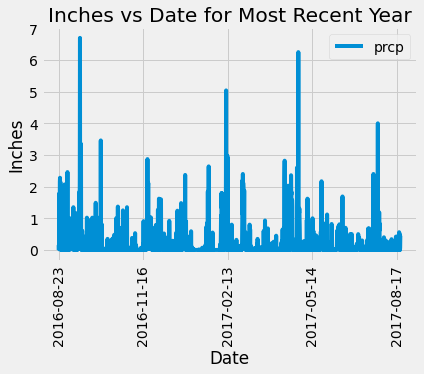

In [178]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
recent_date = dt.datetime.strptime(recent_date, '%Y-%m-%d')
year_before_recent = recent_date - relativedelta(years=1)
# Perform a query to retrieve the data and precipitation scores
data_for_year = session.query(Measurements.date, Measurements.prcp).\
    filter(Measurements.date>=year_before_recent.date()).\
    filter(Measurements.date<=recent_date.date()).order_by(Measurements.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(data_for_year)
prcp_df.set_index('date', inplace = True)
prcp_df.dropna(inplace=True)
# Sort the dataframe by date


# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot()
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Inches vs Date for Most Recent Year')


In [179]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [180]:
# Design a query to calculate the total number stations in the dataset
session.query(Stations).count()

9

In [181]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurements.station, func.count(Measurements.station)).\
group_by(Measurements.station).order_by(func.count(Measurements.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [182]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
lowest_temp = session.query(func.min(Measurements.tobs)).\
    filter(Measurements.station == "USC00519281").all()
lowest_temp = lowest_temp[0][0]
print(f"Lowest Temperature: {lowest_temp} degrees")

highest_temp = session.query(func.max(Measurements.tobs)).\
    filter(Measurements.station == "USC00519281").all()
highest_temp = highest_temp[0][0]
print(f"Highest Temperature: {highest_temp} degrees")

avg_temp = session.query(func.avg(Measurements.tobs)).\
    filter(Measurements.station == "USC00519281").all()
avg_temp = round(avg_temp[0][0],1)
print(f"Average Temperature: {avg_temp} degrees")


Lowest Temperature: 54.0 degrees
Highest Temperature: 85.0 degrees
Average Temperature: 71.7 degrees


Text(0.5, 1.0, 'Frequency of Temperatures for Last Year in Station USC00519281')

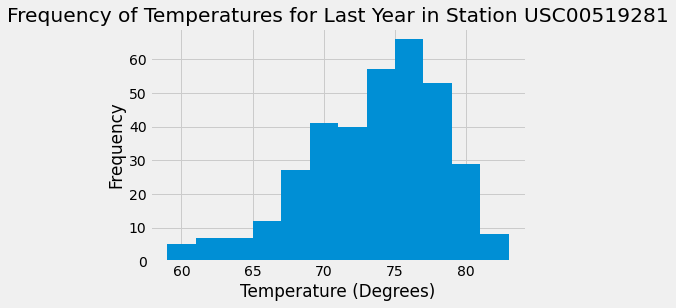

In [183]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_year = session.query(Measurements.date, Measurements.tobs).\
    filter(Measurements.date>=year_before_recent.date()).\
    filter(Measurements.date<=recent_date.date()).\
    filter(Measurements.station == "USC00519281").order_by(Measurements.date).all()

station_df = pd.DataFrame(most_active_station_year)
station_df.set_index('date', inplace = True)
station_df.dropna(inplace=True)


station_df.hist(bins = 12)
plt.xlabel('Temperature (Degrees)')
plt.ylabel('Frequency')
plt.title('Frequency of Temperatures for Last Year in Station USC00519281')

# Close session

In [184]:
# Close Session
session.close()